# Determine SNOTEL sites within polygon
*J. Michelle Hu  
University of Utah  
July 2024*  
---

Load polygons of interest and locate SNOTEL sites enclosed within polygons  
Intended use: 
- obtain period of records
- identify locations for data extraction from NWM outputs, ASO, SWANN, etc.

Modified from https://github.com/snowex-hackweek/website-2021/blob/f5fcda5b49021d24435a9eda61a1bb5003845517/book/tutorials/geospatial/SNOTEL_query.ipynb#L8

In [11]:
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pyproj

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

In [12]:
%reload_ext autoreload
%autoreload 2

## Setup

In [13]:
# SNOTEL PoR directory
snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'

allsites_fn = h.fn_list(snotel_dir, '*active*csv')[0]
sites_df = pd.read_csv(allsites_fn, index_col=0)
sites_df.head()

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num
0,SNTL,AK,Alexander Lake (1267),NaN,2014-August,61.75,-150.89,160,Matanuska-susitna,Upper Alexander Creek (190205051106),1267
1,SNTL,AK,American Creek (1189),NaN,2011-August,64.79,-141.23,1050,Southeast Fairbanks,American Creek (190705050504),1189
2,SNTL,AK,Anchor River Divide (1062),NaN,1980-October,59.86,-151.32,1653,Kenai Peninsula,Headwaters Anchor River (190203010701),1062
3,SNTL,AK,Anchorage Hillside (1070),NaN,2004-October,61.11,-149.67,2080,Anchorage,South Fork Campbell Creek (190204010601),1070
4,SNTL,AK,Aniak (2065),NaN,2002-July,61.58,-159.58,80,Bethel,Aniak Slough-Kuskokwim River (190305020504),2065


## Prepare point geometry objects from lat lon columns

In [14]:
%%time
# add geometry column using shapely Point object and lat lon columns
sites_df['geometry'] = [Point(float(lon), float(lat)) for lon, lat in zip(sites_df['lon'], sites_df['lat'])]

CPU times: user 8.15 ms, sys: 2.05 ms, total: 10.2 ms
Wall time: 9.64 ms


In [15]:
sites_df.head()

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
0,SNTL,AK,Alexander Lake (1267),NaN,2014-August,61.75,-150.89,160,Matanuska-susitna,Upper Alexander Creek (190205051106),1267,POINT (-150.89 61.75)
1,SNTL,AK,American Creek (1189),NaN,2011-August,64.79,-141.23,1050,Southeast Fairbanks,American Creek (190705050504),1189,POINT (-141.23 64.79)
2,SNTL,AK,Anchor River Divide (1062),NaN,1980-October,59.86,-151.32,1653,Kenai Peninsula,Headwaters Anchor River (190203010701),1062,POINT (-151.32 59.86)
3,SNTL,AK,Anchorage Hillside (1070),NaN,2004-October,61.11,-149.67,2080,Anchorage,South Fork Campbell Creek (190204010601),1070,POINT (-149.67 61.11)
4,SNTL,AK,Aniak (2065),NaN,2002-July,61.58,-159.58,80,Bethel,Aniak Slough-Kuskokwim River (190305020504),2065,POINT (-159.58 61.58)


## Specify the correct proj directories for the `work` conda env

In [16]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

In [17]:
pyproj.datadir.set_data_dir('/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj')

## Convert to geodataframe

In [18]:
# specify crs
sites_gdf = gpd.GeoDataFrame(sites_df, crs="EPSG:4326")
sites_gdf.head()

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
0,SNTL,AK,Alexander Lake (1267),NaN,2014-August,61.75,-150.89,160,Matanuska-susitna,Upper Alexander Creek (190205051106),1267,POINT (-150.89000 61.75000)
1,SNTL,AK,American Creek (1189),NaN,2011-August,64.79,-141.23,1050,Southeast Fairbanks,American Creek (190705050504),1189,POINT (-141.23000 64.79000)
2,SNTL,AK,Anchor River Divide (1062),NaN,1980-October,59.86,-151.32,1653,Kenai Peninsula,Headwaters Anchor River (190203010701),1062,POINT (-151.32000 59.86000)
3,SNTL,AK,Anchorage Hillside (1070),NaN,2004-October,61.11,-149.67,2080,Anchorage,South Fork Campbell Creek (190204010601),1070,POINT (-149.67000 61.11000)
4,SNTL,AK,Aniak (2065),NaN,2002-July,61.58,-159.58,80,Bethel,Aniak Slough-Kuskokwim River (190305020504),2065,POINT (-159.58000 61.58000)


## Export the geodataframe as a geojson for later ease of use

In [20]:
out_fn = f'{snotel_dir}/snotel_sites.json'
out_fn

'/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites.json'

In [21]:
# Write to file, default overwrite
sites_gdf.to_file(out_fn, driver='GeoJSON')

In [22]:
# Update the sites_gdf to epsg 32613
sites_gdf_32613 = sites_gdf.to_crs('EPSG:32613')
sites_gdf_32613.head()

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
0,SNTL,AK,Alexander Lake (1267),NaN,2014-August,61.75,-150.89,160,Matanuska-susitna,Upper Alexander Creek (190205051106),1267,POINT (-1762313.614 7710420.840)
1,SNTL,AK,American Creek (1189),NaN,2011-August,64.79,-141.23,1050,Southeast Fairbanks,American Creek (190705050504),1189,POINT (-1144769.537 7677767.857)
2,SNTL,AK,Anchor River Divide (1062),NaN,1980-October,59.86,-151.32,1653,Kenai Peninsula,Headwaters Anchor River (190203010701),1062,POINT (-1931938.273 7560691.969)
3,SNTL,AK,Anchorage Hillside (1070),NaN,2004-October,61.11,-149.67,2080,Anchorage,South Fork Campbell Creek (190204010601),1070,POINT (-1760838.125 7607792.095)
4,SNTL,AK,Aniak (2065),NaN,2002-July,61.58,-159.58,80,Bethel,Aniak Slough-Kuskokwim River (190305020504),2065,POINT (-2116036.185 8055489.936)


In [23]:
# Write to file, default overwrite
out_fn = f'{snotel_dir}/snotel_sites_32613.json'
print(out_fn)
sites_gdf_32613.to_file(out_fn, driver='GeoJSON')

/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json


## Filter sites within input polygon

In [24]:
poly_fn = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys/yampa.shp'

In [25]:
poly_gdf = gpd.read_file(poly_fn)

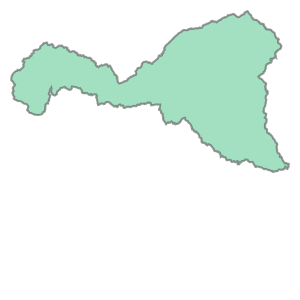

In [26]:
poly_gdf['geometry'].loc[0]

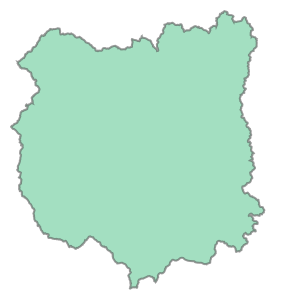

In [27]:
poly_gdf['geometry'].loc[1]

In [28]:
poly_gdf.total_bounds

array([ 157259.05492955, 4426723.90308776,  364793.90898612,
       4529958.89508947])

In [29]:
poly_gdf.iloc[0].geometry.bounds

(157259.05492954975, 4443224.344074166, 284680.1939221991, 4517042.492016298)

In [30]:
poly_gdf.iloc[1].geometry.bounds

(270686.94187872345, 4426723.903087758, 364793.9089861198, 4529958.8950894745)

In [31]:
# do this for the upper yampa - there are no snotel sites in the lower yampa
poly_upper_geom = poly_gdf.iloc[1].geometry

In [32]:
idx = sites_gdf_32613.intersects(poly_upper_geom)
idx.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [33]:
idx.value_counts()

False    892
True       9
Name: count, dtype: int64

In [34]:
poly_snotel_sites = sites_gdf_32613.loc[idx]
poly_snotel_sites

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
136,SNTL,CO,Bear River (1061),NaN,2004-October,40.06,-107.01,9112,Routt,Yamcolo Reservoir-Bear River (140500010102),1061,POINT (328571.157 4436352.347)
145,SNTL,CO,Buffalo Park (913),NaN,1995-September,40.23,-106.60,9249,Grand,Deer Creek-Red Dirt Creek (140100010706),913,POINT (363880.838 4454513.157)
156,SNTL,CO,Crosho (426),NaN,1985-October,40.17,-107.06,8973,Rio Blanco,Hunt Creek (140500010106),426,POINT (324589.434 4448660.396)
160,SNTL,CO,Dry Lake (457),NaN,1979-October,40.53,-106.78,8271,Routt,City of Steamboat Springs-Yampa River (1405000...,457,POINT (349237.123 4488106.853)
163,SNTL,CO,Elk River (467),NaN,1978-October,40.85,-106.97,8739,Routt,Steamboat Lake-Willow Creek (140500010206),467,POINT (333940.154 4523973.535)
188,SNTL,CO,Lost Dog (940),NaN,1998-August,40.82,-106.75,9327,Routt,Outlet North Fork Elk River (140500010203),940,POINT (352419.270 4520249.189)
211,SNTL,CO,Rabbit Ears (709),NaN,1985-October,40.37,-106.74,9411,Routt,Harrison Creek (140500010402),709,POINT (352275.167 4470278.067)
214,SNTL,CO,Ripple Creek (717),NaN,1985-October,40.11,-107.29,10350,Rio Blanco,Snell Creek-North Fork White River (140500050102),717,POINT (304831.374 4442479.757)
229,SNTL,CO,Tower (825),NaN,1978-October,40.54,-106.68,10620,Routt,Fish Creek (140500010407),825,POINT (357728.502 4489050.683)


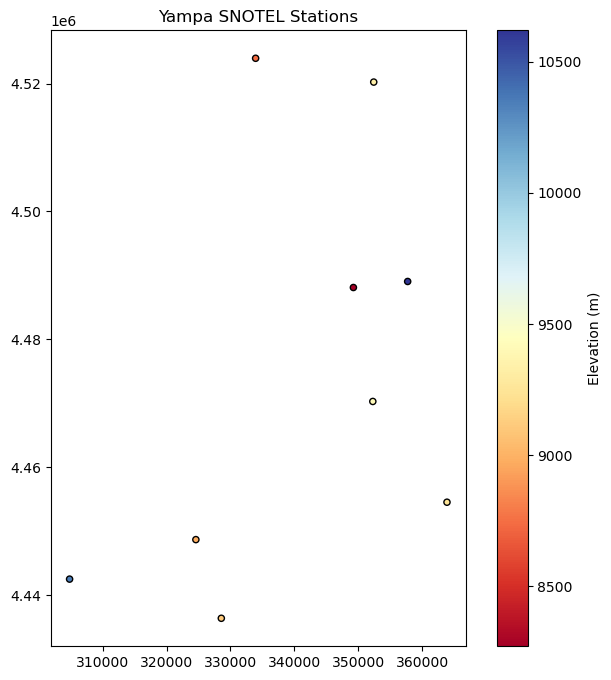

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
poly_snotel_sites.plot(ax=ax, column='elev', markersize=20, edgecolor='k', cmap='RdYlBu', \
                  legend=True, legend_kwds={'label':'Elevation (m)'})
ax.set_title('Yampa SNOTEL Stations');
ax.set_aspect('equal')

## Bundle this up into a function

In [36]:
out_fn

'/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'

In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import unary_union
import pyproj

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

site_locs_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'
poly_fn = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys/yampa.shp'

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
pyproj.datadir.set_data_dir('/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj')

In [3]:
def locate_snotel_in_poly(poly_fn: str, site_locs_fn: str):
    '''
    Extract snotel sites located within snotel polygon
    poly_fn: polygon filepath 
    site_locs_fn:   EPSG 4326 /uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites.json
                    EPSG 32613 /uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json
    Returns a geodataframe of sites located within polygon
    '''
    sites_gdf = gpd.read_file(site_locs_fn)
    poly_gdf = gpd.read_file(poly_fn)

    # merge geometries if multipart polygon
    if len(poly_gdf.geometry) > 1:
        poly_geom = unary_union(poly_gdf.geometry)
    else:        
        poly_geom = poly_gdf.iloc[0].geometry
    
    idx = sites_gdf.intersects(poly_geom)
    poly_sites = sites_gdf.loc[idx]
    
    return poly_sites

In [4]:
found_sites = locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=site_locs_fn)
found_sites

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
136,SNTL,CO,Bear River (1061),None,2004-October,40.06,-107.01,9112,Routt,Yamcolo Reservoir-Bear River (140500010102),1061,POINT (328571.15744 4436352.34706)
145,SNTL,CO,Buffalo Park (913),None,1995-September,40.23,-106.60,9249,Grand,Deer Creek-Red Dirt Creek (140100010706),913,POINT (363880.83767 4454513.15666)
156,SNTL,CO,Crosho (426),None,1985-October,40.17,-107.06,8973,Rio Blanco,Hunt Creek (140500010106),426,POINT (324589.43355 4448660.39629)
160,SNTL,CO,Dry Lake (457),None,1979-October,40.53,-106.78,8271,Routt,City of Steamboat Springs-Yampa River (1405000...,457,POINT (349237.12327 4488106.85307)
163,SNTL,CO,Elk River (467),None,1978-October,40.85,-106.97,8739,Routt,Steamboat Lake-Willow Creek (140500010206),467,POINT (333940.15398 4523973.53493)
188,SNTL,CO,Lost Dog (940),None,1998-August,40.82,-106.75,9327,Routt,Outlet North Fork Elk River (140500010203),940,POINT (352419.26997 4520249.18863)
211,SNTL,CO,Rabbit Ears (709),None,1985-October,40.37,-106.74,9411,Routt,Harrison Creek (140500010402),709,POINT (352275.16748 4470278.06683)
214,SNTL,CO,Ripple Creek (717),None,1985-October,40.11,-107.29,10350,Rio Blanco,Snell Creek-North Fork White River (140500050102),717,POINT (304831.37350 4442479.75675)
229,SNTL,CO,Tower (825),None,1978-October,40.54,-106.68,10620,Routt,Fish Creek (140500010407),825,POINT (357728.50153 4489050.68327)


In [5]:
found_sites.geometry.x.values

array([328571.15743785, 363880.83766538, 324589.4335458 , 349237.1232721 ,
       333940.15398297, 352419.2699726 , 352275.16748111, 304831.37350026,
       357728.50153042])

In [7]:
out_fn = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/yampa_sites.json'

In [8]:
found_sites.to_file(out_fn, driver='GeoJSON')